## Подготовка к работе с данными
### импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
plt.rcParams["figure.figsize"] = (10.0, 7.0)

### Загрузим имеющиеся данные в датафреймы

In [2]:
ABgroup = pd.read_csv('Data/ABgroup.csv', sep=',')
cash = pd.read_csv('Data/Cash.csv', sep=',', parse_dates=['date'], dayfirst=True)
money = pd.read_csv('Data/Money.csv', sep=',', parse_dates=['date'], dayfirst=True)
cheaters = pd.read_csv('Data/Cheaters.csv', sep=',')
platforms = pd.read_csv('Data/Platforms.csv', sep=',')

### так как имеются дубликаты, удалим их в датасетах где нет разбивки по дате

In [3]:
ABgroup.drop_duplicates(inplace=True)
cheaters.drop_duplicates(inplace=True)
platforms.drop_duplicates(inplace=True)

#### Первые два раздела описаны в ворде, и не включают в себя использование кода
# Раздел 3. Очистка данных

### создатим датафрейм с существующими читерами

In [5]:
cheaters_true = cheaters[cheaters['cheaters'] == 1]

### создатим датафрейм с существующими читерами

In [6]:
cheaters_payments = cash.merge(cheaters_true, on='user_id').merge(money, on = ['user_id', 'date'])

In [7]:
cheaters_payments.describe()

,cash,cheaters,money
count,2824.000000,2824.0,2824.0
mean,18350.991501,1.0,0.0
std,16069.479162,0.0,0.0
min,0.000000,1.0,0.0
25%,5200.000000,1.0,0.0
50%,16200.000000,1.0,0.0
75%,28600.000000,1.0,0.0
max,148200.000000,1.0,0.0


#### Так как тест длился 8 дней, фактическое количество читеров в 8 раз меньше, потому что, траты и платы производились каждый день теста

### Посмотрим сколько читеров всего было замечено за период, и на их суммарные донаты и траты валюты игры за период теста

In [8]:
cheaters_payments.groupby('user_id').agg('sum').describe()

,cash,cheaters,money
count,353.000000,353.0,353.0
mean,146807.932011,8.0,0.0
std,33800.925081,0.0,0.0
min,46700.000000,8.0,0.0
25%,125100.000000,8.0,0.0
50%,147200.000000,8.0,0.0
75%,169700.000000,8.0,0.0
max,253150.000000,8.0,0.0


#### Видим, что читеры вообще не производят платежей (донатов)

### Теперь посмотрим на обычных игроков для сравнения

In [9]:
players = cheaters[cheaters['cheaters'] == 0]
players_payment = cash.merge(players, on='user_id').merge(money, on = ['user_id', 'date'])

In [10]:
players_payment.describe()

,cash,cheaters,money
count,8.637176e+06,8637176.0,8.637176e+06
mean,7.576511e+02,0.0,7.492327e-01
std,7.716610e+02,0.0,7.923057e-01
min,0.000000e+00,0.0,0.000000e+00
25%,2.500000e+02,0.0,0.000000e+00
50%,7.000000e+02,0.0,9.900000e-01
75%,1.150000e+03,0.0,9.900000e-01
max,1.377500e+05,0.0,9.990000e+00


### уберем экспоненциальную форму и посмотрим на суммарные траты за период у обычных игроков

In [12]:
pd.options.display.float_format = '{:,.1f}'.format

In [14]:
players_payment.groupby('user_id').agg('sum')[['cash', 'money']].describe()

,cash,money
count,"1,079,647.0","1,079,647.0"
mean,"6,061.2",6.0
std,"3,004.2",1.9
min,50.0,0.0
25%,"5,050.0",5.0
50%,"6,000.0",6.0
75%,"6,950.0",7.0
max,"240,950.0",16.9


### Посмотрим медианы читеров и обычных игроков

In [15]:
print(cheaters_payments.groupby('user_id').agg('sum').median())
print(players_payment.groupby('user_id').agg('sum').median())

cash       147,200.0
cheaters         8.0
money            0.0
dtype: float64
cash       6,000.0
cheaters       0.0
money          6.0
dtype: float64


#### Видно что траты обычных игроков и читеров разнятся в десятки раз. При этом читеры не покупают валюту.

### Найдем всех кто потратил больше 95 квантиля по обычным игрокам и при этом не платил за валюту.

In [16]:
player_level_95 = np.percentile(players_payment.groupby('user_id').agg('sum').cash, 95)

In [18]:
allpeiod_player = players_payment.groupby('user_id').agg('sum')

In [19]:
suspicious_player = allpeiod_player[(allpeiod_player['cash'] > player_level_95) & (allpeiod_player['money'] == 0)]

In [20]:
suspicious_player

,cash,cheaters,money
user_id,,,
027YD0-7N2S50,203400,0,0.0
091QZN-XYWQ8D,78500,0,0.0
0E95BB-LTAHXQ,166000,0,0.0
0GCX0G-5BZ6HE,122650,0,0.0
0GH23F-XS6VSB,152150,0,0.0
...,...,...,...
ZQNX2R-TGBYZ0,147200,0,0.0
ZRQNJL-5G1WXO,97950,0,0.0
ZUEJJE-KN8O77,121400,0,0.0


#### Видим список игроков с подозрительно большими тратами, при этом у них нет покупок валюты. Будем считать их читерами тоже.

### Вернем индекс на место

In [21]:
suspicious_player.reset_index(inplace=True)

### присвоим всем найденым читерам значение 1 в столбце cheaters

In [22]:
cheaters.loc[cheaters['user_id'].isin(suspicious_player['user_id']), 'cheaters'] = 1

### перезапишим датафрейм player, в нем не будет читеров. И добавим к нему разделение по группам

In [23]:
players = cheaters[cheaters['cheaters'] == 0].merge(ABgroup, on = 'user_id')

# Раздел 4. Анализ

### разделим пользователей на группы и сразу добавим их платежи и платформу

In [28]:
test_group = players[players['group'] == 'test']\
.merge(money, on = ['user_id'])
control_group = players[players['group'] == 'control']\
.merge(money, on = ['user_id'])

### удалим более не нужные датафреймы ради экономии памяти

In [30]:
del allpeiod_player
del cheaters
del cheaters_payments
del cheaters_true
del suspicious_player
del players_payment
del ABgroup

NameError: name 'allpeiod_player' is not defined

### Прежде чем считать метрики взглянем на графики и проверим их симметричность и эксцесс, для упрощения бдуем использовать функцию которая находит средние, квартили, медиану, моду, стандартное отклонение, эксцесс и ассиметрию и рисует график. График будет показывать количество игроков (y) и сколько они суммарно задонатили за период теста по оси х

In [66]:
def researh(df, column):
    print("Базовые метрики")
    print(df[column].describe())
    print('Медиана - ', df[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sb.histplot(df[column], binwidth= 1)

### Тестовая группа

Базовые метрики
count   539,312.0
mean          6.2
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          16.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55860
5.0    49457
7.0    40198
4.0    36292
6.9    35217
Name: money, dtype: int64
------------------------------------
Эксцесс  0.026747177605952466
Ассиметрия  0.23717022914455232


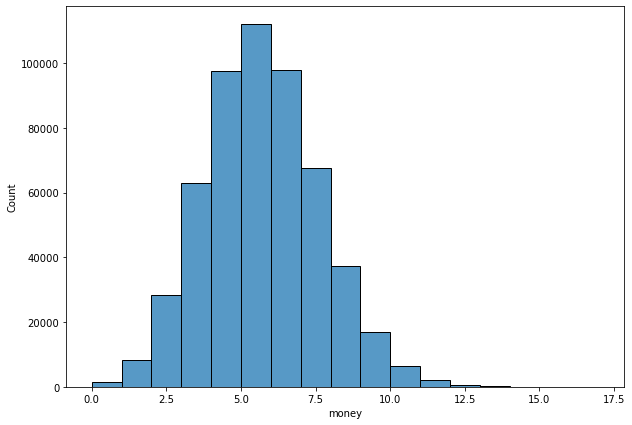

In [67]:
researh(test_group.groupby('user_id').agg('sum'), 'money')

#### Видно что есть ассимтерия, но в целом распределение похоже на нормальное.

### Контрольная группа

Базовые метрики
count   539,991.0
mean          5.8
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55576
5.0    54557
4.0    42771
5.0    37251
7.0    37051
Name: money, dtype: int64
------------------------------------
Эксцесс  0.006912261917506601
Ассиметрия  0.22888980004466286


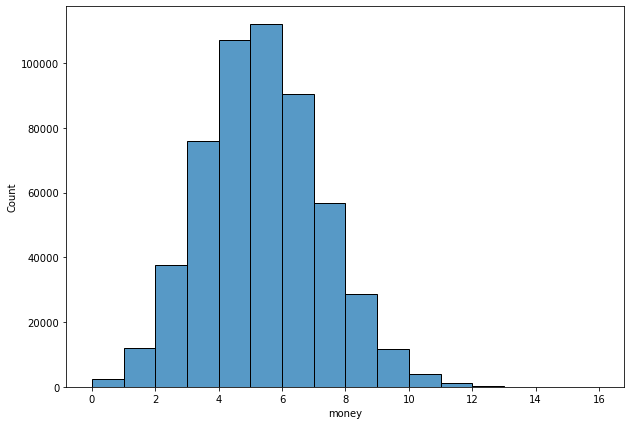

In [68]:
researh(control_group.groupby('user_id').agg('sum'), 'money')

####  Можно сделать вывод что пркатически все игроки донатили хоть раз за период теста, на всякий случай посмотрим сколько вообще не платящих игроков

In [80]:
(test_group.groupby('user_id').agg('sum')['money'] == 0).sum()

76

#### Всего 76 игроков не донатили за период теста

### Теперь найдем  ARPU и ARPPU 

### найдем суммы платежей для каждой группы

In [81]:
print('Сумма платежей тестовой группы - ', test_group_sum := test_group.money.sum())
print('Сумма платежей контрольной группы - ', control_group_sum := control_group.money.sum())

Сумма платежей тестовой группы -  3323389.1799999946
Сумма платежей контрольной группы -  3147865.7900000024


### найдем ARPU

In [83]:
ARPU_test = test_group_sum / test_group.drop_duplicates('user_id').count()[0]
ARPU_control = control_group_sum / control_group.drop_duplicates('user_id').count()[0]
print('ARPU тестовой группы - ', ARPU_test, '\n', 'ARPU контрольной группы - ', ARPU_control)

ARPU тестовой группы -  6.162275602990467 
 ARPU контрольной группы -  5.829478250563439


### также найдем их доверительные интервалы возьмем доверительную вероятность 95%

In [85]:
def confidence(df, column, alpha = 0.95):
    interval = stats.norm.interval(alpha, loc=df[column].mean(), scale=df[column].std())
    return interval

In [86]:
test_confidence = confidence(test_group.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал тестовой группы', test_confidence)
control_confidence = confidence(control_group.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал контрольной группы', control_confidence)

Доверительный интервал тестовой группы (2.417077142534608, 9.907474063461883)
Доверительный интервал контрольной группы (2.1572457079550493, 9.501710793182074)


### Различия не так уж и велики, но все таки у тестовой группы ARPU больше. Однако интервалы пересекаются почти на всю длину. Это может говорить о том что результаты получены случайно.

In [29]:
print('ARPU тестовой группы больше контрольной на ', round((ARPU_test - ARPU_control) / ARPU_control * 100, 1), ' %')

ARPU тестовой группы больше контрольной на  5.7  %


### Теперь найдем ARPPU для этого сначала отделим платящих игроков

In [87]:
df = test_group.groupby('user_id').agg('sum').reset_index()
test_group_paying = df[df['money'] > 0]
df = control_group.groupby('user_id').agg('sum').reset_index()
control_group_paying = df[df['money'] > 0]

In [88]:
test_group.groupby('user_id').agg('sum').reset_index()

,user_id,cheaters,money
0,0004MK-VW0O9L,0,5.0
1,0005S4-UEC6BE,0,6.0
2,0007I5-EWUD6O,0,6.9
3,000IF8-UU506H,0,6.9
4,000IX6-VZLBS1,0,10.9
...,...,...,...
539307,ZZZIS2-9EYJF3,0,4.0
539308,ZZZONB-1W7QEW,0,7.0
539309,ZZZPEX-P2T8BH,0,7.0
539310,ZZZTEN-0QGZ3X,0,6.0


Базовые метрики
count   539,236.0
mean          6.2
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          16.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55860
5.0    49457
7.0    40198
4.0    36292
6.9    35217
Name: money, dtype: int64
------------------------------------
Эксцесс  0.01948786963720961
Ассиметрия  0.24104777717750522


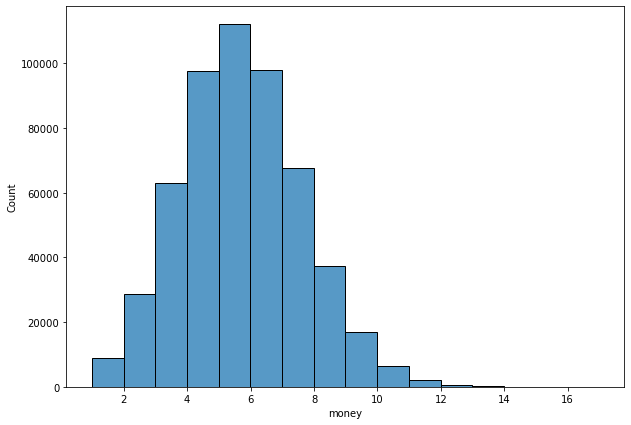

In [93]:
researh(test_group_paying, 'money')

Базовые метрики
count   539,840.0
mean          5.8
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    55576
5.0    54557
4.0    42771
5.0    37251
7.0    37051
Name: money, dtype: int64
------------------------------------
Эксцесс  -0.004748696740484171
Ассиметрия  0.23563197648757012


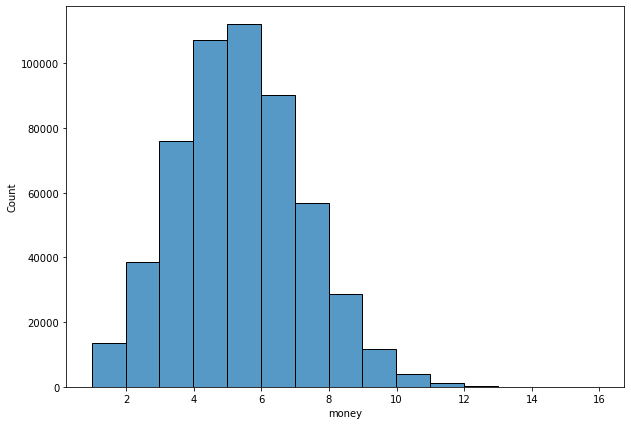

In [92]:
researh(control_group_paying, 'money')

#### Так как в этих выборках были только платящие игроки, на 0 нет никого, а сами графики слабо различаются т.к. неплатящих игроков всего 76

### найдем ARPPU 

In [94]:
ARPPU_test = test_group_sum / test_group_paying.drop_duplicates('user_id').count()[0]
ARPPU_control = control_group_sum / control_group_paying.drop_duplicates('user_id').count()[0]
print('ARPPU тестовой группы - ', ARPPU_test, '\n', 'ARPPU контрольной группы - ', ARPPU_control)

ARPPU тестовой группы -  6.163144115007149 
 ARPPU контрольной группы -  5.831108828541795


In [95]:
test_paying_confidence = confidence(test_group_paying.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал тестовой группы', test_paying_confidence)
control_paying_confidence = confidence(control_group_paying.groupby('user_id').agg('sum'), 'money')
print('Доверительный интервал контрольной группы', control_paying_confidence)

Доверительный интервал тестовой группы (2.420427728875802, 9.905860501154054)
Доверительный интервал контрольной группы (2.163338538245194, 9.498879118848642)


In [96]:
print('ARPPU тестовой группы больше контрольной на ', round((ARPPU_test - ARPPU_control) / ARPPU_control * 100, 1), ' %')

ARPPU тестовой группы больше контрольной на  5.7  %


### Интервалы пересекаются на обоих метриках, это говорит о случайности результатов, результат от акции может быть и есть но слабый.

### проверим те же метрики для групп разных платформ.

In [97]:
test_group_PC = platforms[platforms['platform'] == 'PC'].merge(test_group, on = 'user_id')
test_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(test_group, on = 'user_id')
test_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(test_group, on = 'user_id')
control_group_PC = platforms[platforms['platform'] == 'PC'].merge(control_group, on = 'user_id')
control_group_PS4 = platforms[platforms['platform'] == 'PS4'].merge(control_group, on = 'user_id')
control_group_Xbox = platforms[platforms['platform'] == 'XBox'].merge(control_group, on = 'user_id')

### создадим немного более удобную функцию исследования

In [119]:
def all_research(df, column = 'money', alpha = 0.95):
    df_all = df.groupby('user_id').agg('sum').reset_index()
    print("Базовые метрики - все игроки")
    print(df_all[column].describe())
    print('Медиана - ', df_all[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_all[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_all[column]))
    print("Ассиметрия ", skew(df_all[column]))
    
    
    
    print('Сумма', df_all[column].sum())
    ARPU = df_all[column].sum() / df_all.drop_duplicates('user_id').count()[0]
    print('ARPU - ', ARPU)
    
    interval = stats.norm.interval(alpha, loc=df_all[column].mean(), scale=df_all[column].std())
    print('Доверительный интервал средней для всех', interval)
    print('-'* 20)
    print('-'* 20)
    
    dfs = df.groupby('user_id').agg('sum').reset_index()
    df_p = dfs[dfs['money'] > 0]
    
    print("Базовые метрики - платящие игроки")
    print(df_p[column].describe())
    print('Медиана - ', df_p[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_p[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_p[column]))
    print("Ассиметрия ", skew(df_p[column]))
    
    
    
    ARPPU = df_p[column].sum() / df_p.drop_duplicates('user_id').count()[0]
    
    print('ARPPU - ', ARPPU)
    
    interval = stats.norm.interval(alpha, loc=df_p[column].mean(), scale=df_p[column].std())
    print('Доверительный интервал средней для платящих', interval)
    
    
    all_plot = sb.histplot(df_all[column], color='yellow', bins=15,  binwidth= 1);
    all_plot.set_title('Все игроки группы')
    plt.show()
    paying_plot = sb.histplot(df_p[column], bins = 15, binwidth= 1, legend='Платящие игроки');
    paying_plot.set_title('Платящие игроки группы')

### описание тестовой группы игроков на ПК

Базовые метрики - все игроки
count   179,820.0
mean          6.3
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.9
max          16.9
Name: money, dtype: float64
Медиана -  5.96
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18850
5.0    15995
7.0    13609
6.9    12138
4.0    11562
Name: money, dtype: int64
------------------------------------
Эксцесс  0.04797887632809106
Ассиметрия  0.24937041981274452
Сумма 1127299.88
ARPU -  6.269046157268379
Доверительный интервал средней для всех (2.487105299473276, 10.05098701502758)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,800.0
mean          6.3
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.9
max          16.9
Name: money, dtype: float64
Медиана -  5.96
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18850
5.0    15995
7.0    13609
6.9    12138


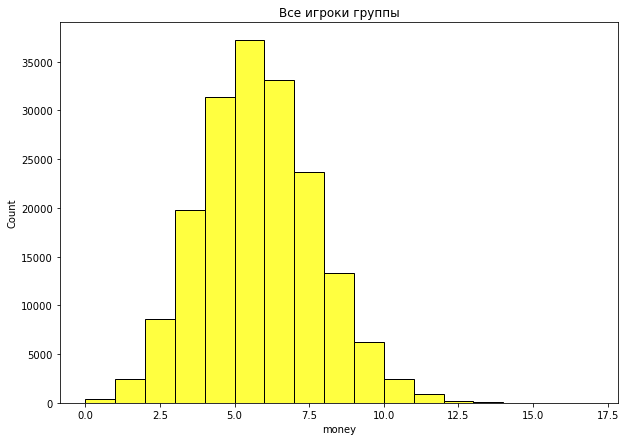

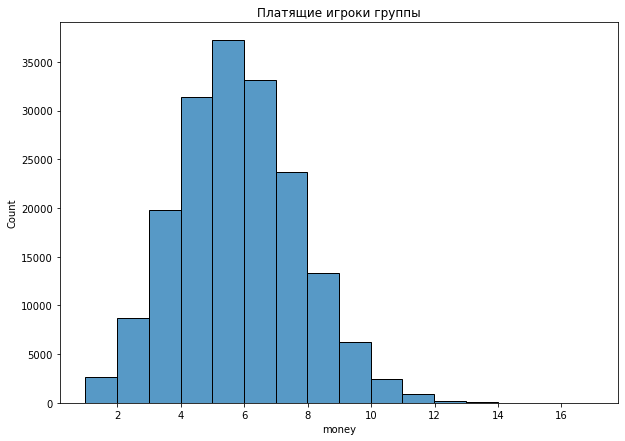

In [120]:
all_research(test_group_PC)

### описание контрольной грппы игроков на ПК

Базовые метрики - все игроки
count   179,732.0
mean          5.6
std           1.8
min           0.0
25%           4.0
50%           5.9
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.9399999999999995
------------------------------------
Самые популярные значения метрики, топ 5
5.0    19237
6.0    18918
4.0    15515
5.0    12858
7.0    11808
Name: money, dtype: int64
------------------------------------
Эксцесс  0.007294703110581668
Ассиметрия  0.20938340950020856
Сумма 1014803.06
ARPU -  5.6462013442236225
Доверительный интервал средней для всех (2.0852347204284074, 9.207167967987086)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,665.0
mean          5.6
std           1.8
min           1.0
25%           4.0
50%           5.9
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.9399999999999995
------------------------------------
Самые популярные значения метрики, топ 5
5.0    19237
6.0    1

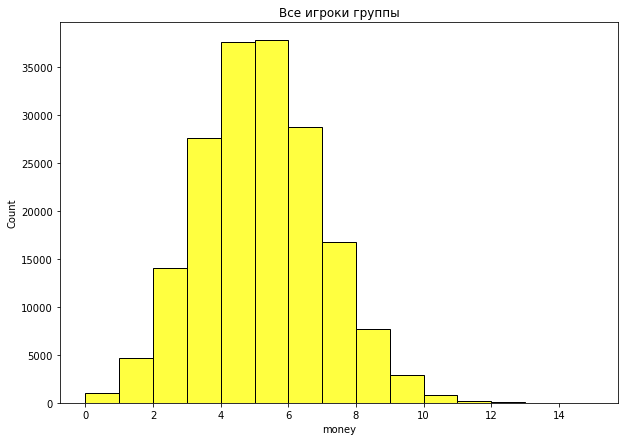

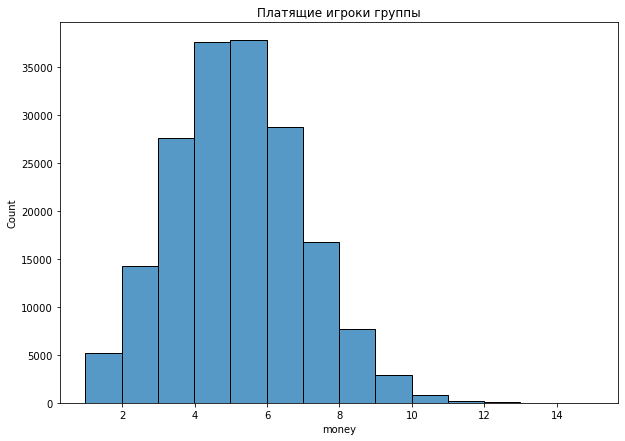

In [121]:
all_research(control_group_PC)

#### ARPU и ARPPU также выше у тестовой группы для игроков на ПК

### описание контрольной грппы игроков на ПК

Базовые метрики - все игроки
count   179,415.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18512
5.0    16961
7.0    13321
4.0    12532
5.0    11722
Name: money, dtype: int64
------------------------------------
Эксцесс  0.005903475589768448
Ассиметрия  0.21822758720072233
Сумма 1091719.2100000002
ARPU -  6.08488259064181
Доверительный интервал средней для всех (2.3902870056128545, 9.779478175636244)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,386.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18512
5.0    16961
7.0    13321
4.0 

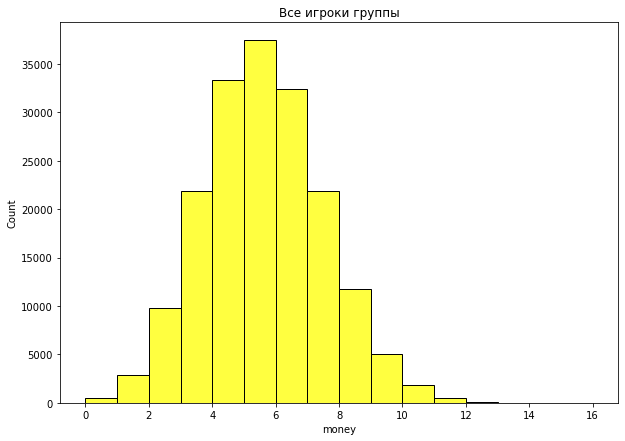

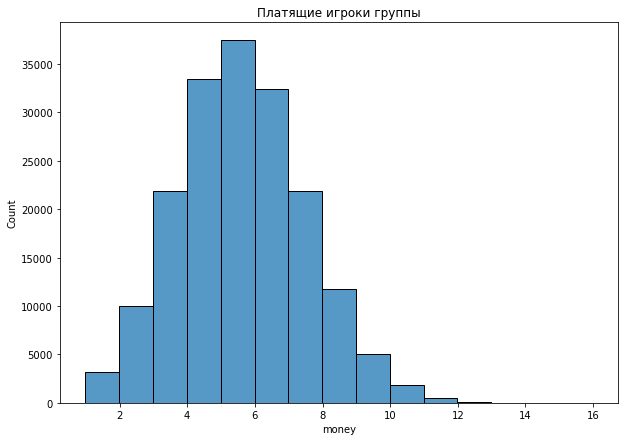

In [122]:
all_research(test_group_PS4)

### описание контрольной группы игроков на ПС4

Базовые метрики - все игроки
count   179,804.0
mean          5.7
std           1.9
min           0.0
25%           4.0
50%           6.0
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
5.0    18389
6.0    18113
4.0    14827
5.0    12557
7.0    11980
Name: money, dtype: int64
------------------------------------
Эксцесс  -0.03658336978708654
Ассиметрия  0.21783101352028067
Сумма 1031651.8699999999
ARPU -  5.73764693777669
Доверительный интервал средней для всех (2.0782611436421083, 9.397032731878994)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,747.0
mean          5.7
std           1.9
min           1.0
25%           4.0
50%           6.0
75%           7.0
max          14.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
5.0    18389
6.0    18113
4.0    14827
5.0 

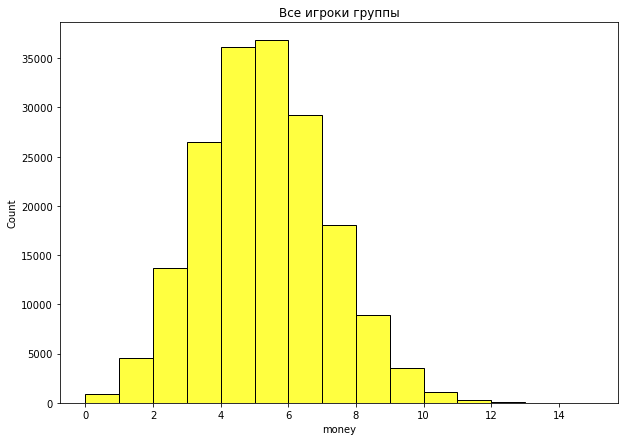

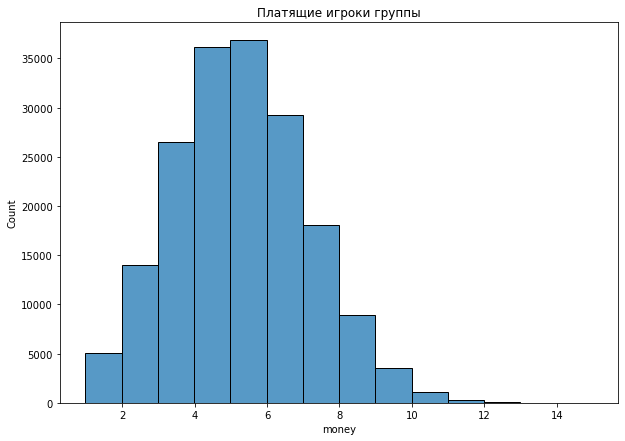

In [123]:
all_research(control_group_PS4)

#### Показатели ARPU ARPPU тестовой группы также больше контрольной, но при этом меньше чем у группы на игроков ПК

### описание тестовой группы игроков на иксбокс

Базовые метрики - все игроки
count   180,077.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18498
5.0    16501
7.0    13268
4.0    12198
5.0    11751
Name: money, dtype: int64
------------------------------------
Эксцесс  0.012458503010370325
Ассиметрия  0.23785999509845931
Сумма 1104370.09
ARPU -  6.1327659279086175
Доверительный интервал средней для всех (2.383687674723918, 9.881844181058247)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,050.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18498
5.0    16501
7.0    13268
4.0    1219

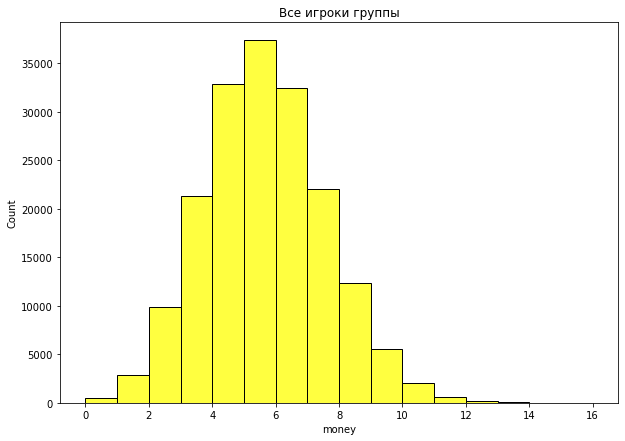

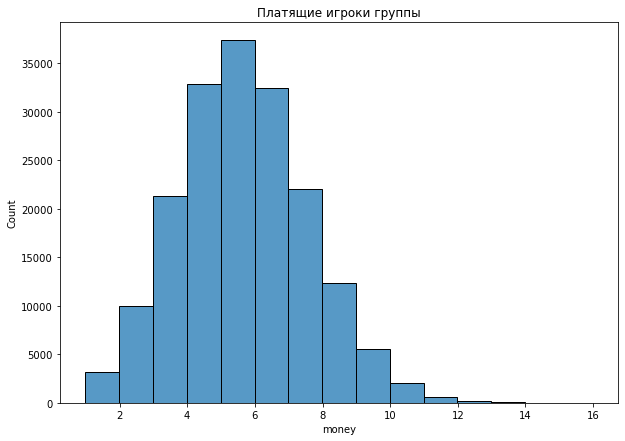

In [124]:
all_research(test_group_Xbox)

### описание контрольной группы игроков на иксбокс

Базовые метрики - все игроки
count   180,455.0
mean          6.1
std           1.9
min           0.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18545
5.0    16931
7.0    13263
4.0    12429
5.0    11836
Name: money, dtype: int64
------------------------------------
Эксцесс  0.007546259405377231
Ассиметрия  0.23325578640234226
Сумма 1101410.8599999999
ARPU -  6.103520877781164
Доверительный интервал средней для всех (2.371017420681194, 9.836024334846265)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,428.0
mean          6.1
std           1.9
min           1.0
25%           5.0
50%           6.0
75%           7.0
max          15.9
Name: money, dtype: float64
Медиана -  5.95
------------------------------------
Самые популярные значения метрики, топ 5
6.0    18545
5.0    16931
7.0    13263
4.0 

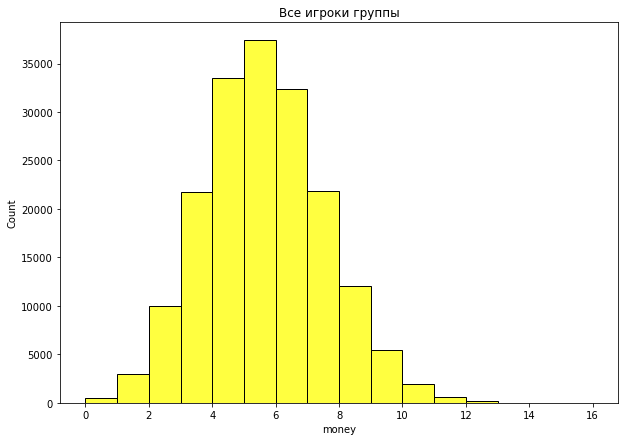

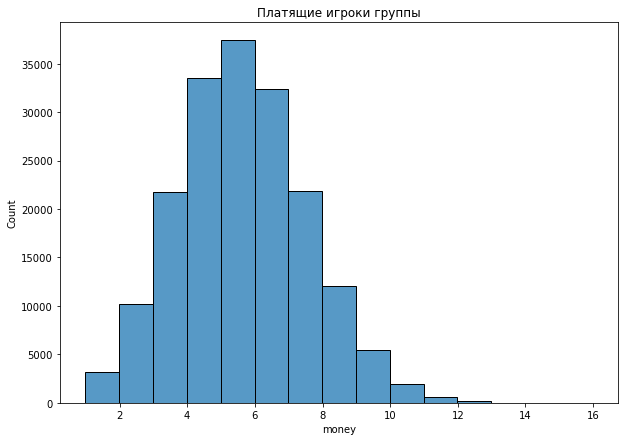

In [125]:
all_research(control_group_Xbox)

#### На игроков на иксбокс акция не подействовала практически никак, наиболее сильный эффект от акции был на игроках на ПК, послабее для игроков на ПС4.

### Раздел 5. Отчёт

### Добавим метрики ARSU, ARSPU которые представляют из себя коэффициент суммарная трата за период / кол-во игроков(платящих игроков). изменим наименования метрик, и увеличим разбиение в графиках, график будет показывать количество игроков по оси У и их суммарные траты валюты на оси Х.

In [132]:
def all_research(df, column = 'money', alpha = 0.95):
    df_all = df.groupby('user_id').agg('sum').reset_index()
    print("Базовые метрики - все игроки")
    print(df_all[column].describe())
    print('Медиана - ', df_all[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_all[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_all[column]))
    print("Ассиметрия ", skew(df_all[column]))
    
    
    
    print('Сумма', df_all[column].sum())
    ARSU = df_all[column].sum() / df_all.drop_duplicates('user_id').count()[0]
    print('ARSU - ', ARSU)
    
    interval = stats.norm.interval(alpha, loc=df_all[column].mean(), scale=df_all[column].std())
    print('Доверительный интервал средней для всех', interval)
    print('-'* 20)
    print('-'* 20)
    
    dfs = df.groupby('user_id').agg('sum').reset_index()
    df_p = dfs[dfs['money'] > 0]
    
    print("Базовые метрики - платящие игроки")
    print(df_p[column].describe())
    print('Медиана - ', df_p[column].median())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df_p[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df_p[column]))
    print("Ассиметрия ", skew(df_p[column]))
    
    
    
    ARSPU = df_p[column].sum() / df_p.drop_duplicates('user_id').count()[0]
    
    print('ARSPU - ', ARSPU)
    
    interval = stats.norm.interval(alpha, loc=df_p[column].mean(), scale=df_p[column].std())
    print('Доверительный интервал средней для платящих', interval)
    
    
    all_plot = sb.histplot(df_all[column], color='yellow', bins=40);
    all_plot.set_title('Все игроки')
    plt.show()
    paying_plot = sb.histplot(df_p[column], bins = 40, legend='Платящие игроки');
    paying_plot.set_title('Платящие игроки')

### добавим колонку с тратой валюты

In [129]:
test_group = test_group.merge(cash, on=['user_id', 'date'])
control_group = control_group.merge(cash, on=['user_id', 'date'])

### Тестовая группа

Базовые метрики - все игроки
count   539,312.0
mean      6,229.6
std       1,411.4
min         100.0
25%       5,300.0
50%       6,250.0
75%       7,200.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6250.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    7737
6200    7695
6100    7660
6450    7631
6000    7605
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.006093711613086583
Ассиметрия  0.010217085257937361
Сумма 3359696050
ARSU -  6229.596319013855
Доверительный интервал средней для всех (3463.289304234267, 8995.903333793442)
--------------------
--------------------
Базовые метрики - платящие игроки
count   539,236.0
mean      6,230.0
std       1,411.0
min         100.0
25%       5,300.0
50%       6,250.0
75%       7,200.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6250.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    7737
6200    7695
6100    7660
6450    76

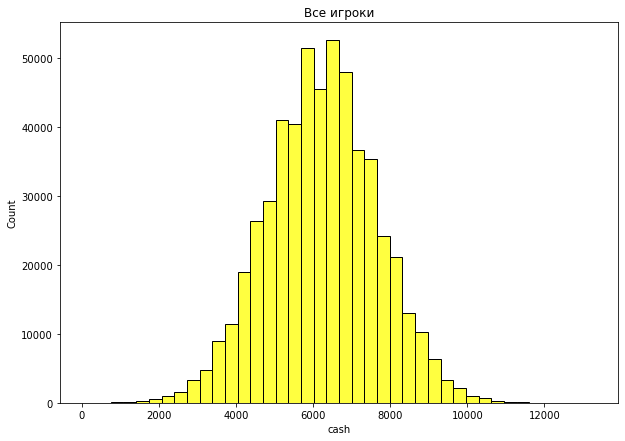

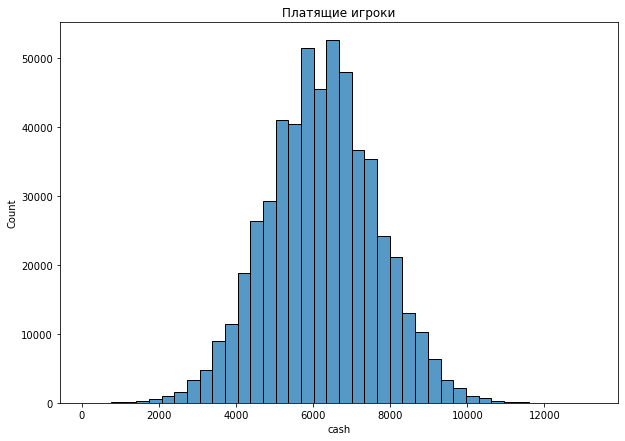

In [133]:
all_research(test_group, 'cash')

### контрольная группа

Базовые метрики - все игроки
count   539,991.0
mean      5,800.7
std       1,347.1
min          50.0
25%       4,900.0
50%       5,800.0
75%       6,700.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  5800.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    8234
5850    8176
6050    8060
5750    8033
5600    8021
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.03639547405548127
Ассиметрия  0.044479811298419145
Сумма 3132328700
ARSU -  5800.705382126739
Доверительный интервал средней для всех (3160.4640590387303, 8440.946705214748)
--------------------
--------------------
Базовые метрики - платящие игроки
count   539,840.0
mean      5,801.4
std       1,346.5
min          50.0
25%       4,900.0
50%       5,800.0
75%       6,700.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  5800.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    8234
5850    8176
6050    8060
5750    80

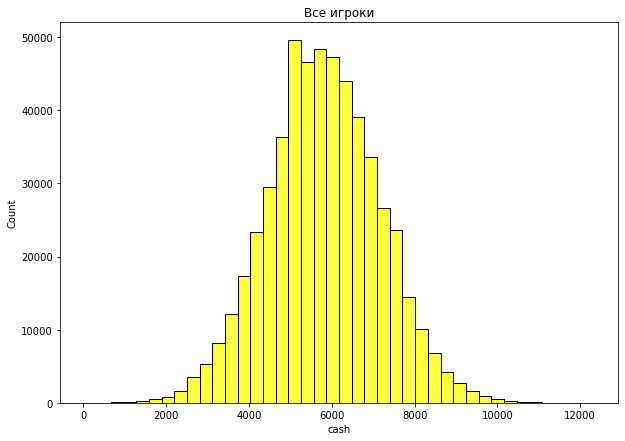

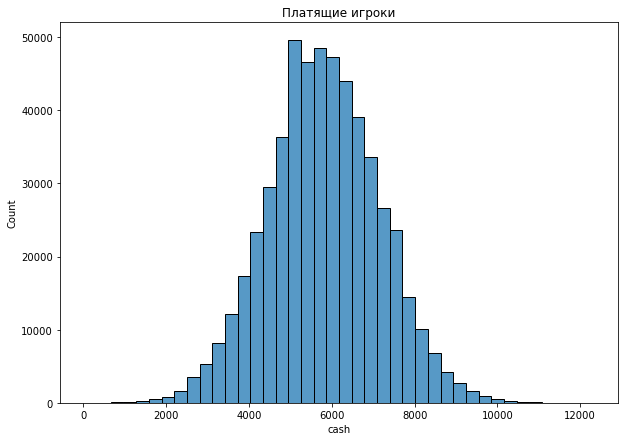

In [134]:
all_research(control_group, 'cash')

### добавим столбец платежей в существующие датафреймы

In [135]:
test_group_PC = test_group_PC.merge(cash, on = ['user_id', 'date'])
test_group_PS4 = test_group_PS4.merge(cash, on = ['user_id', 'date'])
test_group_Xbox = test_group_Xbox.merge(cash, on = ['user_id', 'date'])
control_group_PC = control_group_PC.merge(cash, on = ['user_id', 'date'])
control_group_PS4 = control_group_PS4.merge(cash, on = ['user_id', 'date'])
control_group_Xbox = control_group_Xbox.merge(cash, on = ['user_id', 'date'])

### Исследуем тестовую группу игроков на ПК

Базовые метрики - все игроки
count   179,820.0
mean      6,381.7
std       1,456.3
min         100.0
25%       5,400.0
50%       6,400.0
75%       7,350.0
max      12,700.0
Name: cash, dtype: float64
Медиана -  6400.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    2527
6450    2502
6650    2502
6100    2476
6200    2453
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.00691655344235631
Ассиметрия  -0.004635102042471981
Сумма 1147565500
ARSU -  6381.745634523412
Доверительный интервал средней для всех (3527.490304225572, 9236.000964821253)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,800.0
mean      6,382.1
std       1,456.0
min         100.0
25%       5,400.0
50%       6,400.0
75%       7,350.0
max      12,700.0
Name: cash, dtype: float64
Медиана -  6400.0
------------------------------------
Самые популярные значения метрики, топ 5
6400    2527
6450    2502
6650    2502
6100    2

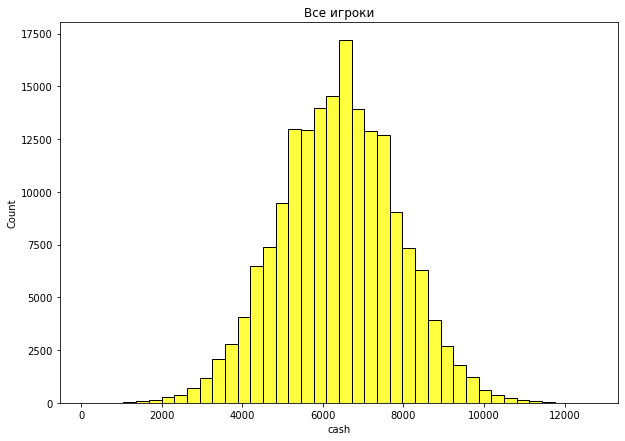

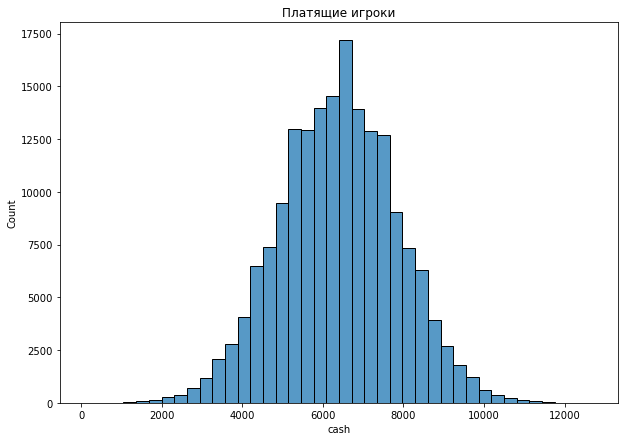

In [136]:
all_research(test_group_PC, 'cash')

### Исследуем контрольную группу игроков на ПК

Базовые метрики - все игроки
count   179,732.0
mean      5,587.1
std       1,238.5
min          50.0
25%       4,750.0
50%       5,600.0
75%       6,400.0
max      11,350.0
Name: cash, dtype: float64
Медиана -  5600.0
------------------------------------
Самые популярные значения метрики, топ 5
5550    2964
5700    2961
5600    2954
5500    2922
5650    2882
Name: cash, dtype: int64
------------------------------------
Эксцесс  0.02336671947937674
Ассиметрия  -0.006913814380671639
Сумма 1004181050
ARSU -  5587.102185476153
Доверительный интервал средней для всех (3159.7836793857646, 8014.420691566542)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,665.0
mean      5,588.0
std       1,237.8
min          50.0
25%       4,750.0
50%       5,600.0
75%       6,400.0
max      11,350.0
Name: cash, dtype: float64
Медиана -  5600.0
------------------------------------
Самые популярные значения метрики, топ 5
5550    2964
5700    2961
5600    2954
5500    2

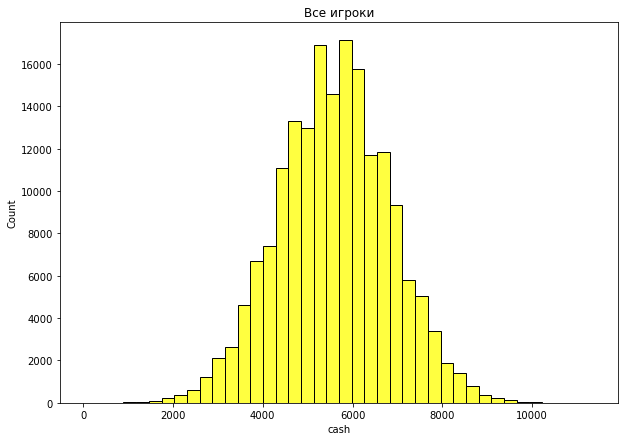

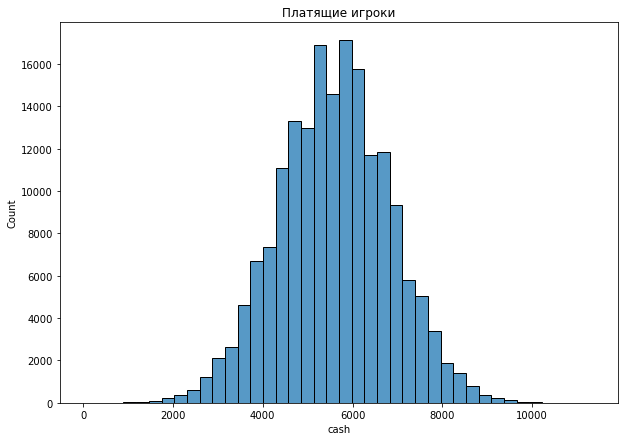

In [137]:
all_research(control_group_PC, 'cash')

### Тестовая группа игроков на ПС4

Базовые метрики - все игроки
count   179,415.0
mean      6,130.5
std       1,362.2
min         100.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6100    2666
6200    2658
6000    2655
5800    2644
6050    2636
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.0022666108463544887
Ассиметрия  -0.008803924709465174
Сумма 1099902450
ARSU -  6130.4932697934955
Доверительный интервал средней для всех (3460.5664381068054, 8800.420101480186)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,386.0
mean      6,130.9
std       1,361.9
min         100.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      13,250.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6100    2666
6200    2658
6000    2655
5800 

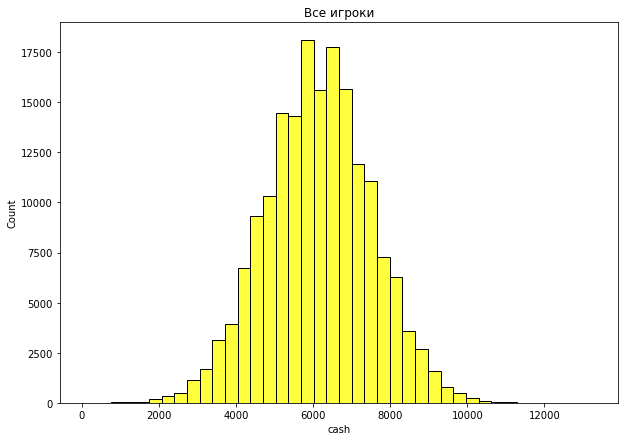

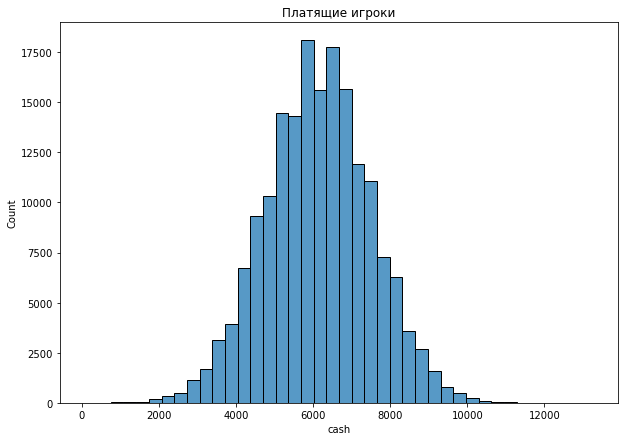

In [138]:
all_research(test_group_PS4, 'cash')

### Контрольная группа игроков на ПС4

Базовые метрики - все игроки
count   179,804.0
mean      5,681.9
std       1,334.4
min          50.0
25%       4,800.0
50%       5,700.0
75%       6,600.0
max      11,600.0
Name: cash, dtype: float64
Медиана -  5700.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    2768
5850    2748
5500    2721
5750    2716
5600    2704
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.012463456882148893
Ассиметрия  -0.009713017986440616
Сумма 1021634850
ARSU -  5681.936163822829
Доверительный интервал средней для всех (3066.57092390516, 8297.3014037405)
--------------------
--------------------
Базовые метрики - платящие игроки
count   179,747.0
mean      5,682.7
std       1,333.8
min          50.0
25%       4,800.0
50%       5,700.0
75%       6,600.0
max      11,600.0
Name: cash, dtype: float64
Медиана -  5700.0
------------------------------------
Самые популярные значения метрики, топ 5
5700    2768
5850    2748
5500    2721
5750    271

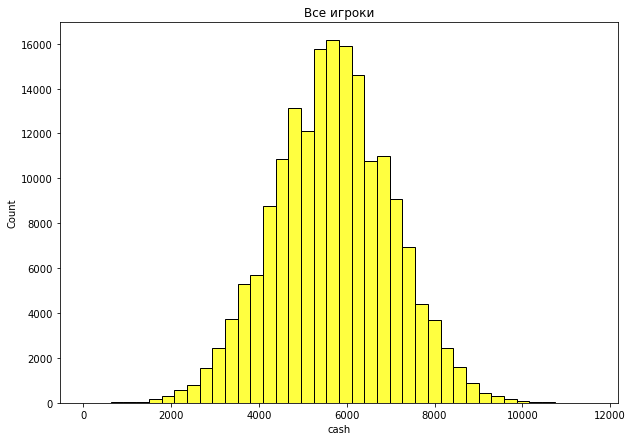

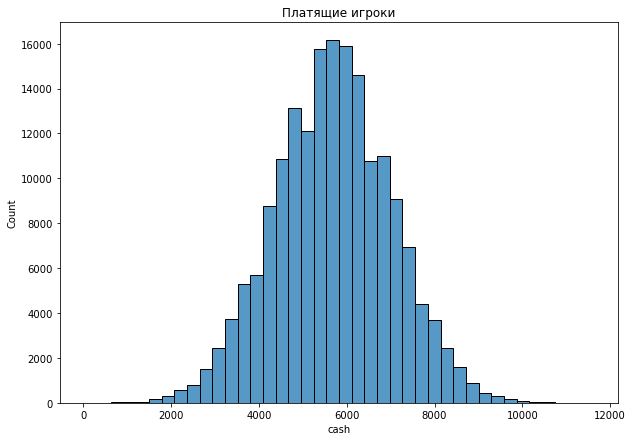

In [139]:
all_research(control_group_PS4, 'cash')

### Тестовая группа игроков на иксбокс

Базовые метрики - все игроки
count   180,077.0
mean      6,176.4
std       1,401.3
min         150.0
25%       5,250.0
50%       6,200.0
75%       7,100.0
max      12,450.0
Name: cash, dtype: float64
Медиана -  6200.0
------------------------------------
Самые популярные значения метрики, топ 5
6300    2637
6350    2615
6400    2606
5900    2594
6000    2589
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.0007575675274424931
Ассиметрия  0.006007650551653336
Сумма 1112228100
ARSU -  6176.402872104711
Доверительный интервал средней для всех (3429.8260479286673, 8922.979696280754)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,050.0
mean      6,176.8
std       1,400.9
min         150.0
25%       5,250.0
50%       6,200.0
75%       7,100.0
max      12,450.0
Name: cash, dtype: float64
Медиана -  6200.0
------------------------------------
Самые популярные значения метрики, топ 5
6300    2637
6350    2615
6400    2606
5900   

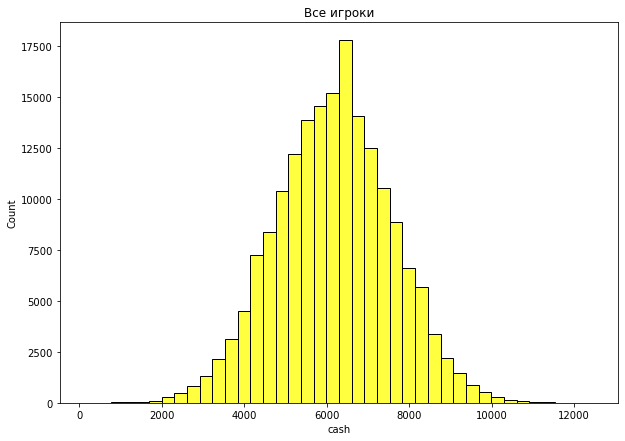

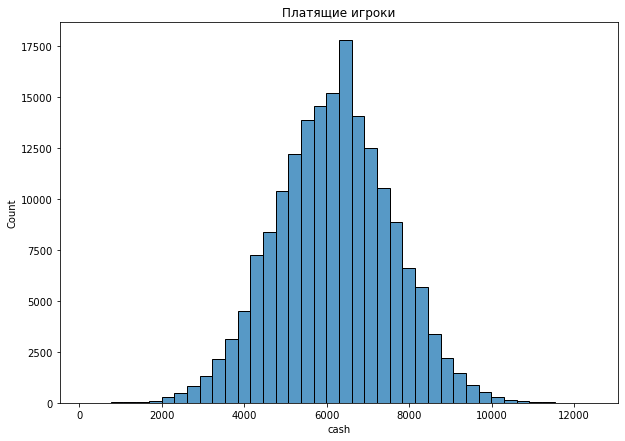

In [140]:
all_research(test_group_Xbox, 'cash')

### Контрольная группа игроков на иксбокс

Базовые метрики - все игроки
count   180,455.0
mean      6,131.8
std       1,399.7
min         250.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6050    2649
6350    2598
5900    2592
6100    2592
6000    2575
Name: cash, dtype: int64
------------------------------------
Эксцесс  -0.003319192521404002
Ассиметрия  0.0005730065121141638
Сумма 1106512800
ARSU -  6131.7935219306755
Доверительный интервал средней для всех (3388.3958264174894, 8875.191217443862)
--------------------
--------------------
Базовые метрики - платящие игроки
count   180,428.0
mean      6,132.2
std       1,399.3
min         250.0
25%       5,200.0
50%       6,150.0
75%       7,050.0
max      12,300.0
Name: cash, dtype: float64
Медиана -  6150.0
------------------------------------
Самые популярные значения метрики, топ 5
6050    2649
6350    2598
5900    2592
6100  

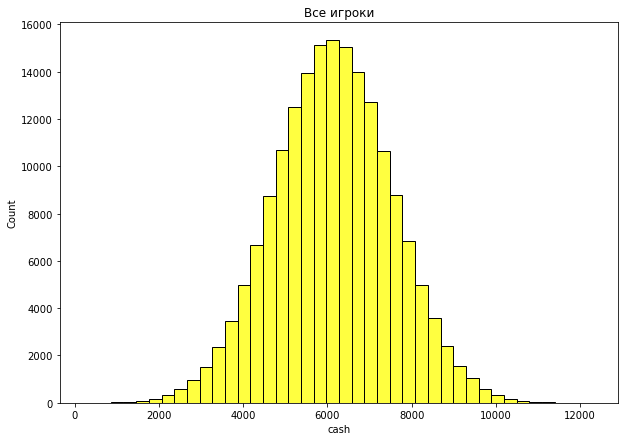

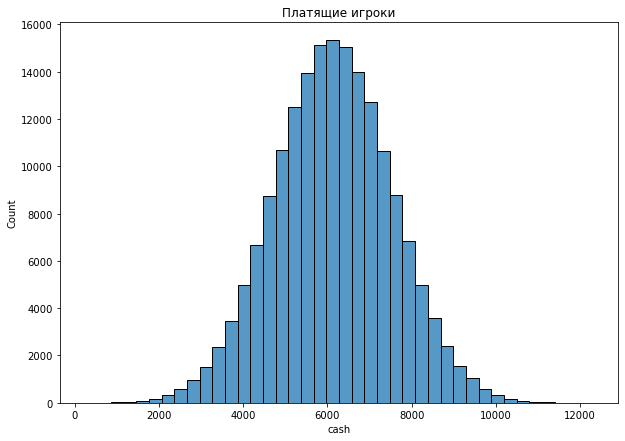

In [141]:
all_research(control_group_Xbox, 'cash')

### подготовим датафрейм который позже преобразуем в csv для PowerBI, в нем должны быть столбцы с нашими метриками по дням

In [142]:
powerbi_test = test_group.groupby('date').agg('sum')

In [143]:
powerbi_test['users'] = test_group.groupby('date').agg('count')['user_id'][1]

### так как во все дни количесвто платящих и не платящих одинаково, в столбец платящих игроков можно ввести константу, в противном случае можно сгруппировать по дате с количеством игроков и добавить столбец с игроками в наш датафрейм

In [146]:
df = test_group.groupby('user_id').agg('sum').reset_index().drop(columns='cheaters')
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money', 'cash']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date'])\
.groupby('date').agg('count')['user_id'].reset_index())


### Переименуем столбец, затем соеденим с существующим датафреймом и добавим метрики по дням

In [148]:
df.rename(columns={'user_id' : 'paying_users'}, inplace=True)

In [149]:
powerbi_test = powerbi_test.merge(df, on='date')

In [150]:
powerbi_test['ARPU'] = powerbi_test['money'] / powerbi_test['users']

In [151]:
powerbi_test['ARPPU'] = powerbi_test['money'] / powerbi_test['paying_users']
powerbi_test['ARSU'] = powerbi_test['cash'] / powerbi_test['users']
powerbi_test['ARSPU'] = powerbi_test['cash'] / powerbi_test['paying_users']

### удалим ненужнй столбец

In [152]:
powerbi_test.drop(columns='cheaters', inplace=True)

In [153]:
powerbi_test

,date,money,cash_x,cash_y,cash,users,paying_users,ARPU,ARPPU,ARSU,ARSPU
0,2021-07-10,"410,341.9",439980100,439980100,439980100,539312,539236,0.8,0.8,815.8,815.9
1,2021-07-11,"410,937.9",440212450,440212450,440212450,539312,539236,0.8,0.8,816.2,816.4
2,2021-07-12,"409,077.7",437566350,437566350,437566350,539312,539236,0.8,0.8,811.3,811.5
3,2021-07-13,"400,947.8",428022700,428022700,428022700,539312,539236,0.7,0.7,793.6,793.8
4,2021-07-14,"383,022.8",402593600,402593600,402593600,539312,539236,0.7,0.7,746.5,746.6
5,2021-07-15,"353,538.5",356375500,356375500,356375500,539312,539236,0.7,0.7,660.8,660.9
6,2021-07-16,"314,611.7",290573050,290573050,290573050,539312,539236,0.6,0.6,538.8,538.9
7,2021-07-17,"640,910.7",564372300,564372300,564372300,539312,539236,1.2,1.2,"1,046.5","1,046.6"


### Так как количество пользователей неизменно, а период прибыли теперь день, ARPU и остальные метрики ниже по сравнению с метриками за весь период теста

### сохраним в csv

In [154]:
powerbi_test.to_csv('power_test.csv',index=False)

### повторим то же самое для контрольной группы

In [155]:
powerbi_control = control_group.groupby('date').agg('sum')
powerbi_control['users'] = control_group.groupby('date').agg('count')['user_id'][1]
df = control_group.groupby('user_id').agg('sum').reset_index().drop(columns='cheaters')
df = df[df['money'] > 0]
df = pd.DataFrame(df.drop(columns=['money', 'cash']).merge(money, on = 'user_id').merge(cash, on = ['user_id', 'date'])\
.groupby('date').agg('count')['user_id'].reset_index())
df.rename(columns={'user_id' : 'paying_users'}, inplace=True)
powerbi_control = powerbi_control.merge(df, on='date')
powerbi_control['ARPU'] = powerbi_control['money'] / powerbi_control['users']
powerbi_control['ARPPU'] = powerbi_control['money'] / powerbi_control['paying_users']
powerbi_control['ARSU'] = powerbi_control['cash'] / powerbi_control['users']
powerbi_control['ARSPU'] = powerbi_control['cash'] / powerbi_control['paying_users']
powerbi_control.drop(columns='cheaters', inplace=True)
powerbi_control

,date,money,cash_x,cash_y,cash,users,paying_users,ARPU,ARPPU,ARSU,ARSPU
0,2021-07-10,"393,870.2",414345600,414345600,414345600,539991,539840,0.7,0.7,767.3,767.5
1,2021-07-11,"392,476.6",413883550,413883550,413883550,539991,539840,0.7,0.7,766.5,766.7
2,2021-07-12,"390,787.8",411404650,411404650,411404650,539991,539840,0.7,0.7,761.9,762.1
3,2021-07-13,"382,743.8",401374950,401374950,401374950,539991,539840,0.7,0.7,743.3,743.5
4,2021-07-14,"364,514.4",376459800,376459800,376459800,539991,539840,0.7,0.7,697.2,697.4
5,2021-07-15,"335,543.7",331369100,331369100,331369100,539991,539840,0.6,0.6,613.7,613.8
6,2021-07-16,"299,028.2",269428450,269428450,269428450,539991,539840,0.6,0.6,498.9,499.1
7,2021-07-17,"588,901.1",514062600,514062600,514062600,539991,539840,1.1,1.1,952.0,952.2


In [156]:
powerbi_control.to_csv('power_control.csv',index=False)

#### Теперь подготовим эксель файл для сводной таблицы ARPU по группам и платформам. Для этого нужна таблица с количеством игроков, их платформой, группой, и суммарным платежом за период.

In [157]:
excel = money.groupby('user_id').agg('sum').reset_index()\
.merge(platforms, on='user_id').merge(players, on='user_id')\
.drop(columns='cheaters')


In [158]:
df = excel.groupby(['platform', 'group']).agg('sum').reset_index()
df = df.merge(excel.groupby(['platform', 'group']).agg('count').reset_index()[['user_id', 'platform', 'group']], on=['platform', 'group'])

In [159]:
df.rename(columns={'user_id' : 'users'}, inplace=True)


In [160]:
df.to_excel('table.xlsx')